In [55]:
import pandas as pd
import pprint
import urllib
import requests
pp = pprint.PrettyPrinter(indent=4)
from yanytapi import SearchAPI
from gensim.similarities.index import AnnoyIndexer
from gensim.models import Word2Vec
from mittens import GloVe, Mittens
from gensim.matutils import corpus2csc
from gensim.corpora import Dictionary
from collections import defaultdict
import numpy as np
import csv
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
% matplotlib inline
import os
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from gensim.parsing.preprocessing import remove_stopwords
#api = SearchAPI("TjGk9kxFO9ScvfSF8AfeqkXjjujBnz6e")

UsageError: Line magic function `%` not found.


In [127]:
def get_df(years=None):
    if not years:
        return pd.concat([pd.read_csv(file) for file in os.listdir() if 'articles' in file], ignore_index=True, sort=False)
    else:
        return pd.concat([pd.read_csv(csv_name(year)) for year in years], ignore_index=True, sort=False)

def get_sentence_list(years=None, only_weed=False):
    df = get_df(years=years)
    df['text'] = df['text'].map(process_strings)
    df['text'] = df['text'].map(remove_stopwords)
    if only_weed:
        paragraphs = [remove_waste(p.split()) for p in df['text'] if 'marijuana' in p or 'cannabis' in p]
    else:
        paragraphs = [remove_waste(p.split()) for p in df['text']]
    return paragraphs

def get_list(years=None, only_weed=False):
    return [item for sublist in get_sentence_list(years, only_weed) for item in sublist]

def get_sentence(years=None):
    split_it = get_list(years)
    return ' '.join(split_it)

def process_strings(s):
    s = s.lower()
    s = s.replace("’","'")
    s = s.replace("'s","")
    bad_chars = ".;:''?!,\[]”“()\""
    for char in bad_chars:
        s = s.replace(char, "")
    if len(s) > 0 and s[0] == '$':
        return '$'
    return s
    
def csv_name(year):
    return 'articles-' + str(year) + '.csv'

def remove_waste(sentence):
    wasted_words = ['—', '&', '-']
    return [word for word in sentence if word not in wasted_words]

def co_occurrence(df, window=5):
    print("co-occurrence")
    sentences = [remove_waste(list(map(lambda s : process_strings(s), p.split()))) for p in df['text']]
    d = dict()
    for sentence in sentences:
        for i in range(len(sentence)):
            if sentence[i] not in d:
                d[sentence[i]] = defaultdict(int)
            for j in range(-window, window):
                if i+j >= 0 and i+j < len(sentence) and i != j: 
                    d[sentence[i]][sentence[i+j]] += 1
    return d

def trim_d(d):
    print("trimming")
    vocab = list(d.keys())
    print(len(vocab))
    for word in d:
        if sum([v for k, v in dict(d[word]).items()]) < 100:
            vocab.remove(word)
    print(len(vocab))
    return {k:d[k] for k in vocab}

def d_to_matrix(d):
    print("matrixing")
    vocab = list(d.keys())
    matrix = np.zeros((len(vocab), len(vocab)))
    for i in range(len(vocab)):
        for j in range(len(vocab)):
            matrix[i][j] = d[vocab[i]][vocab[j]]
    return vocab, matrix

def generate_embeddings(df):
    d = co_occurrence(df)
    trimmed = trim_d(d)
    vocab, cooccurrence = d_to_matrix(d)
    glove_model = GloVe(n=25, max_iter=100)
    embeddings = glove_model.fit(cooccurrence)
    return vocab, embeddings

def glove2dict(glove_filename):
    with open(glove_filename, encoding="utf8") as f:
        reader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONE)
        embed = {line[0]: np.array(list(map(float, line[1:])))
                for line in reader}
    return embed


def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,100), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

# 2010s

In [125]:
years = (2019, 2018, 2017)

Word2Vec(vocab=16410, size=100, alpha=0.025)


C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\index.py:184: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  index = AnnoyIndex(num_features)


[('marijuana', 1.0), ('cigarettes', 0.5210573375225067), ('license', 0.517901599407196), ('amounts', 0.5065646469593048), ('thc', 0.5065595209598541), ('vaping', 0.4989663362503052), ('substances', 0.4978001117706299)]
[('cannabis', 1.0), ('pot', 0.7126578986644745), ('products', 0.6918469071388245), ('hemp', 0.6896823644638062), ('tobacco', 0.6765983998775482), ('cbd', 0.658437579870224), ('oil', 0.6519677042961121)]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


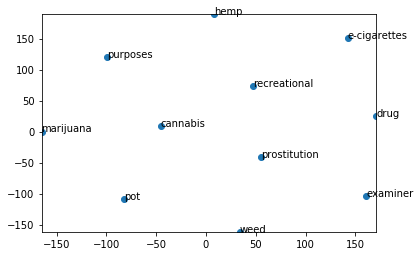

In [124]:
sentences = get_sentence_list(years=years)
model = Word2Vec(sentences,min_count=10)
print(model)
words = list(model.wv.vocab)
indexer = AnnoyIndexer(model, 2)
print(model.wv.most_similar("marijuana", topn=7, indexer=indexer))
print(model.wv.most_similar("cannabis", topn=7, indexer=indexer))
display_closestwords_tsnescatterplot(model, "marijuana")

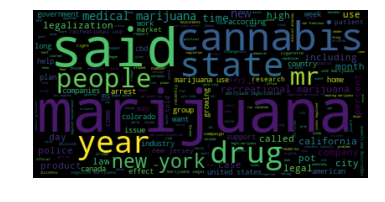

In [126]:
split_it = get_list(years=years, only_weed=True)
wordcloud = WordCloud().generate(' '.join(split_it))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# 2000s

Word2Vec(vocab=14304, size=100, alpha=0.025)


C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\index.py:184: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  index = AnnoyIndex(num_features)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0

[('marijuana', 1.0), ('pot', 0.6863948702812195), ('drugs', 0.6400682032108307), ('cannabis', 0.6155126988887787), ('drug', 0.5808272957801819), ('alcohol', 0.5346662998199463), ('purposes', 0.5236632227897644)]
[('cannabis', 1.0), ('hemp', 0.7124754190444946), ('pot', 0.6963552832603455), ('alcohol', 0.656122475862503), ('plant', 0.6547457277774811), ('treatment', 0.6434619426727295), ('illegal', 0.6323381066322327)]


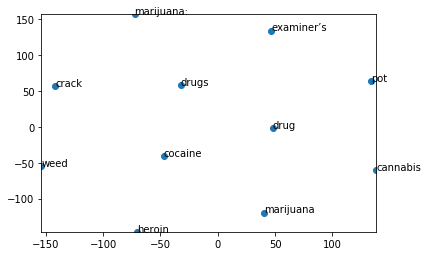

In [8]:
df = pd.concat([pd.read_csv(csv_name(year)) for year in [2009, 2008, 2007]], ignore_index=True, sort=False)
sentences = remove_waste([list(map(lambda s : process_strings(s), p.split())) for p in df['text']])
model = Word2Vec(sentences, min_count=10)
print(model)
words = list(model.wv.vocab)
indexer = AnnoyIndexer(model, 2)
print(model.most_similar("marijuana", topn=7, indexer=indexer))
print(model.most_similar("cannabis", topn=7, indexer=indexer))
display_closestwords_tsnescatterplot(model, "marijuana")

# 1990s

Word2Vec(vocab=9662, size=100, alpha=0.025)


C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\index.py:184: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  index = AnnoyIndex(num_features)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0

[('marijuana', 1.0), ('drugs', 0.7060811519622803), ('cocaine', 0.7001461982727051), ('crack', 0.6946124732494354), ('heroin', 0.6902281641960144), ('positive', 0.6706052124500275), ('alcohol', 0.6168093979358673)]
[('cannabis', 1.0), ('sale', 0.8060154318809509), ('banned', 0.7924846410751343), ('distribution', 0.7648186534643173), ('colombian', 0.7517357468605042), ('properties', 0.7455272376537323), ('misdemeanor', 0.7446663975715637)]


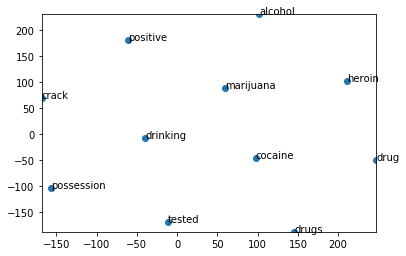

In [9]:
df = pd.concat([pd.read_csv(csv_name(year)) for year in [1999, 1998, 1997]], ignore_index=True, sort=False)
sentences = remove_waste([list(map(lambda s : process_strings(s), p.split())) for p in df['text']])
model = Word2Vec(sentences, min_count=10)
print(model)
words = list(model.wv.vocab)
indexer = AnnoyIndexer(model, 2)
print(model.wv.most_similar("marijuana", topn=7, indexer=indexer))
print(model.wv.most_similar("cannabis", topn=7, indexer=indexer))
display_closestwords_tsnescatterplot(model, "marijuana")

# 1980s

Word2Vec(vocab=8041, size=100, alpha=0.025)


C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\index.py:184: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  index = AnnoyIndex(num_features)


[('marijuana', 0.9998273665260058), ('cocaine', 0.8280745446681976), ('possession', 0.8096036463975906), ('pounds', 0.7529552727937698), ('heroin', 0.7414975762367249), ('amounts', 0.7277330756187439), ('metric', 0.7228276431560516)]
[('cannabis', 1.0), ('pathological', 0.9594958275556564), ('foolish', 0.9584885537624359), ('harm', 0.9580055065453053), ('dose', 0.9545883685350418), ('occurring', 0.9537604786455631), ('distinguish', 0.9526271224021912)]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


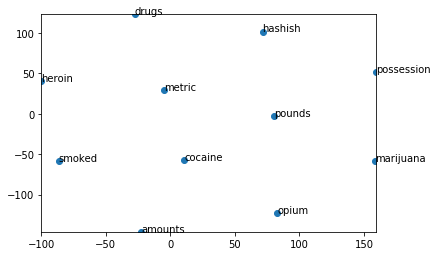

In [123]:
sentences = get_sentence_list(years=(1989,1988,1987))
model = Word2Vec(sentences,min_count=10)
print(model)
words = list(model.wv.vocab)
indexer = AnnoyIndexer(model, 2)
print(model.wv.most_similar("marijuana", topn=7, indexer=indexer))
print(model.wv.most_similar("cannabis", topn=7, indexer=indexer))
display_closestwords_tsnescatterplot(model, "marijuana")

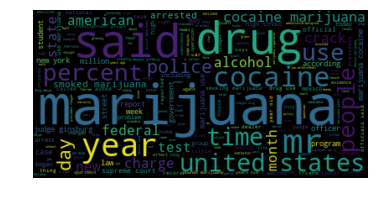

In [107]:
df = pd.concat([pd.read_csv(csv_name(year)) for year in [1989, 1988, 1987]], ignore_index=True, sort=False)
df['text'] = df['text'].map(process_strings)
df['text'] = df['text'].map(remove_stopwords)
paragraphs = [remove_waste(p.split()) for p in df['text'] if 'marijuana' in p or 'cannabis' in p]
split_it = [item for sublist in paragraphs for item in sublist]

wordcloud = WordCloud().generate(' '.join(split_it))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [97]:
df = pd.concat([pd.read_csv(csv_name(year)) for year in [1989, 1988, 1987]], ignore_index=True, sort=False)
df['text'] = df['text'].map(process_strings)
df['text'] = df['text'].map(remove_stopwords)
paragraphs = [remove_waste(p.split()) for p in df['text'] if 'marijuana' in p or 'cannabis' in p]
split_it = [item for sublist in paragraphs for item in sublist]

  
# Pass the split_it list to instance of Counter class. 
Counter = Counter(split_it) 
  
# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur = Counter.most_common(10) 
  
print(most_occur) 

[('marijuana', 2088), ('said', 830), ('drug', 599), ('cocaine', 560), ('mr', 535), ('use', 399), ('drugs', 365), ('police', 243), ('judge', 226), ('years', 226)]


# Comprehensive

Word2Vec(vocab=37405, size=100, alpha=0.025)


C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\index.py:184: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  index = AnnoyIndex(num_features)


[('marijuana', 1.0), ('pot', 0.7335039377212524), ('cannabis', 0.6779657006263733), ('cigarettes', 0.5330028831958771), ('cigarette', 0.5023938417434692), ('juul', 0.44508469104766846), ('smokers', 0.42838525772094727)]
[('cannabis', 1.0), ('pot', 0.6955058872699738), ('marijuana', 0.6779657006263733), ('cigarettes', 0.5443070232868195), ('juul', 0.5387072861194611), ('cigarette', 0.5000960230827332), ('smokers', 0.4689441919326782)]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


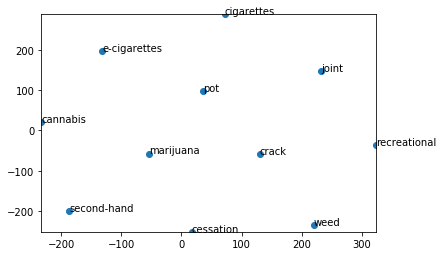

In [122]:
sentences = get_sentence_list()
model = Word2Vec(sentences,min_count=10)
print(model)
words = list(model.wv.vocab)
indexer = AnnoyIndexer(model, 2)
print(model.wv.most_similar("marijuana", topn=7, indexer=indexer))
print(model.wv.most_similar("cannabis", topn=7, indexer=indexer))
display_closestwords_tsnescatterplot(model, "marijuana")

In [128]:
print(len(get_list()), " tokens")
print(len(get_df()['id'].unique()), " articles")

6590429  tokens
10494  articles


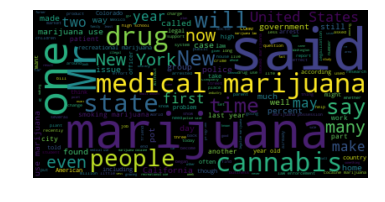

In [48]:
paragraphs = pd.concat([pd.read_csv(file) for file in os.listdir() if 'articles' in file], ignore_index=True, sort=False)['text']
paragraphs = [p for p in paragraphs if 'marijuana' in p or 'cannabis' in p]
wordcloud = WordCloud().generate(''.join(paragraphs))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [117]:
split_it = get_list((2019, 2018, 2017))#[item for sublist in paragraphs for item in sublist]
  
# Pass the split_it list to instance of Counter class. 
Counter = Counter(split_it) 
  
# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur = Counter.most_common(10) 
  
print(most_occur) 

TypeError: 'Counter' object is not callable

In [129]:
import pandas as pd
df = pd.read_csv('articles/articles-2006.csv')
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.date
df.loc[df['date'] == pd.Timestamp('2006-10-31')]

,Unnamed: 0,Unnamed: 0.1,date,id,p#,text,title,url


In [137]:
df.loc[df['title'] == 'Reactionary Moderates']['url'].unique()

array(['https://www.nytimes.com/2006/11/12/opinion/12ponnuru.html',
       'https://www.nytimes.com/2006/11/12/opinion/reactionary-moderates.html'],
      dtype=object)

In [153]:
df = pd.read_csv('articles/articles-2006.csv')
(df['title'] + (pd.to_datetime(df['date']).dt.date).apply(str))[0]

'Back in View, a First Lady With Her Own Legacy2006-12-31'

In [160]:
date = df['date'][0]
str(pd.to_datetime(date)).split(' ')[0]

'2006-12-31'